Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'http://commondatastorage.googleapis.com/books1000/'

def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

Extracting data for notMNIST_large. This may take a while. Please wait.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
Extracting data for notMNIST_small. This may take a while. Please wait.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

---
Answer 1
========
I did some basic code to select a random set of files and then used Ipython.display.Image and Ipython.display.display to display them.

---

In [4]:
## Display a sample of the images

import glob, random

image_files = glob.glob(os.path.join(os.path.dirname(train_folders[0]), '*','*.png'))
example_images = random.sample(image_files, 5)
print(example_images)

def display_samples(filenames):
    for f in filenames:
        print(f)
        image = Image(filename=f)
        display(image)
    
display_samples(example_images)

['notMNIST_large/H/S2VubmVkeS5vdGY=.png', 'notMNIST_large/A/UHJlc2VudG9yLU5vcm1hbC50dGY=.png', 'notMNIST_large/H/Q29uZ3Jlc3MtUmVndWxhckl0YS5vdGY=.png', 'notMNIST_large/B/QWRhbXMgQ29uZGVuc2VkIEl0YWxpYy50dGY=.png', 'notMNIST_large/H/RWxhbkJRLU1lZGl1bUl0YWxpYy5vdGY=.png']
notMNIST_large/H/S2VubmVkeS5vdGY=.png


notMNIST_large/A/UHJlc2VudG9yLU5vcm1hbC50dGY=.png


notMNIST_large/H/Q29uZ3Jlc3MtUmVndWxhckl0YS5vdGY=.png


notMNIST_large/B/QWRhbXMgQ29uZGVuc2VkIEl0YWxpYy50dGY=.png


notMNIST_large/H/RWxhbkJRLU1lZGl1bUl0YWxpYy5vdGY=.png


Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [5]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  for image_index, image in enumerate(image_files):
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[image_index, :, :] = image_data
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  num_images = image_index + 1
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling notMNIST_large/A.pickle.
notMNIST_large/A
Could not read: notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : cannot identify image file 'notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png' - it's ok, skipping.
Could not read: notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file 'notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - it's ok, skipping.
Could not read: notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file 'notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - it's ok, skipping.
Full dataset tensor: (52912, 28, 28)
Mean: -0.128243
Standard deviation: 0.44311
Pickling notMNIST_large/B.pickle.
notMNIST_large/B
Could not read: notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file 'notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - it's ok, skipping.
Full dataset tensor: (52912, 28, 28)
Mean: -0.00756289
Standard deviation: 0.454487
Pickling notMNIST_large/C.pic

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

---
Answer 2
========

I select a randome pickle file of a dataset and then use matplotlib.pyplot and the imshow() routine to show it.

In order to make these plots work in IPython, I have to use the IPython command '%matplotlib inline'.

---

notMNIST_large/E.pickle


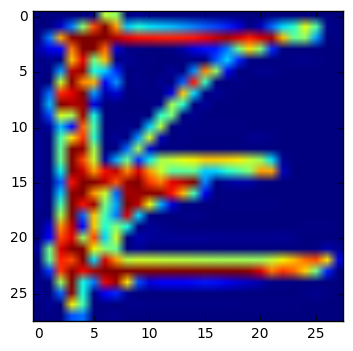

In [6]:
# Verify that the data still looks good after creating the pickle file for each letter
#   use matplotlib.pyplot

sample_dataset_pickle_filename = random.choice(train_datasets)
print(sample_dataset_pickle_filename)
with open(sample_dataset_pickle_filename, 'rb') as d:
    letter_set = pickle.load(d)
%matplotlib inline
random_index = random.randint(0, len(letter_set))
plt.imshow(letter_set[random_index])

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [8]:
# Verify that the data is balanced across classes (letters)

for picklefile in train_datasets:
    with open(picklefile) as p:
        letter_set = pickle.load(p)
    print('%s: %s' % (picklefile, letter_set.shape))
print('Done')

notMNIST_large/A.pickle: (52912, 28, 28)
notMNIST_large/B.pickle: (52912, 28, 28)
notMNIST_large/C.pickle: (52912, 28, 28)
notMNIST_large/D.pickle: (52912, 28, 28)
notMNIST_large/E.pickle: (52912, 28, 28)
notMNIST_large/F.pickle: (52912, 28, 28)
notMNIST_large/G.pickle: (52912, 28, 28)
notMNIST_large/H.pickle: (52912, 28, 28)
notMNIST_large/I.pickle: (52912, 28, 28)
notMNIST_large/J.pickle: (52911, 28, 28)
Done


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [9]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [10]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

---
Answer 4
========

In order to make many figures show up (instead of the latest one overwriting the last one), I have to give each a plt.figure() number.

---

(200000, 28, 28) (200000,)
(10000, 28, 28) (10000,)


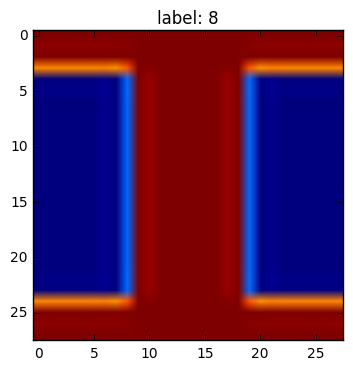

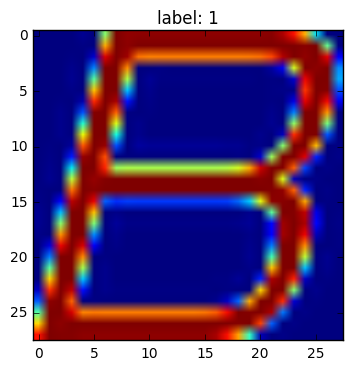

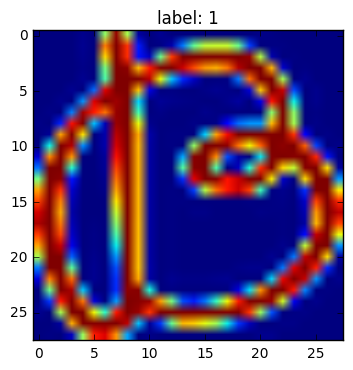

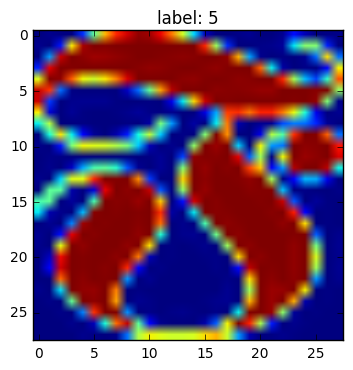

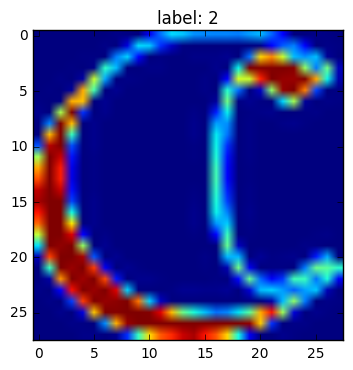

In [12]:
# Make sure data is still good after randomization

num_plots = 5

print(train_dataset.shape, train_labels.shape)
print(test_dataset.shape, test_labels.shape)
indices = random.sample(xrange(len(train_dataset)), num_plots)
%matplotlib inline
for i in indices:
    #print 'label: %s' % train_labels[i]
    #plt.subplot(num_plots, 1, i)
    plt.figure(i)
    plt.title('label: %s' % train_labels[i])
    plt.imshow(train_dataset[i])

Finally, let's save the data for later reuse:

In [13]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [14]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800441


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [16]:
import time

def fast_overlaps_num_set_and_hash(images1, images2):
    images1.flags.writeable=False
    images2.flags.writeable=False
    hash1 = set([hash(image1.data) for image1 in images1])
    hash2 = set([hash(image2.data) for image2 in images2])
    all_overlaps = set.intersection(hash1, hash2)
    return len(all_overlaps)

def find_dups_and_overlaps(images1, images2):
    images1.flags.writeable=False
    images2.flags.writeable=False
    dup_table={}
    duplicates1 = []
    for idx,img in enumerate(images1):
        h = hash(img.data)
        if h in dup_table and (images1[dup_table[h]].data == img.data):
            duplicates1.append((idx, dup_table[h]))
            #print 'Duplicate image: %d matches %d' % (idx, dup_table[h])
        dup_table[h] = idx
    overlaps = []
    for idx,img in enumerate(images2):
        h = hash(img.data)
        if h in dup_table and (images1[dup_table[h]].data == img.data):
            overlaps.append((dup_table[h], idx))
            #print 'Test image %d is in the training set' % idx
    return duplicates1, overlaps

def num_overlaps_with_diff_labels(overlap_indices, labels1, labels2):
    count = 0
    for olap in overlap_indices:
        if labels1[olap[0]] != labels2[olap[1]]:
            count += 1
    return count

def faster_overlaps_hashlib_and_numpy():
    import hashlib

    train_hashes = [hashlib.sha1(x).digest() for x in train_dataset]
    valid_hashes = [hashlib.sha1(x).digest() for x in valid_dataset]
    test_hashes  = [hashlib.sha1(x).digest() for x in test_dataset]

    valid_in_train = np.in1d(valid_hashes, train_hashes)
    test_in_train  = np.in1d(test_hashes,  train_hashes)
    test_in_valid  = np.in1d(test_hashes,  valid_hashes)

    valid_keep = ~valid_in_train
    test_keep  = ~(test_in_train | test_in_valid)

    valid_dataset_clean = valid_dataset[valid_keep]
    valid_labels_clean  = valid_labels [valid_keep]

    test_dataset_clean = test_dataset[test_keep]
    test_labels_clean  = test_labels [test_keep]

    print("valid -> train overlap: %d samples" % valid_in_train.sum())
    print("test  -> train overlap: %d samples" % test_in_train.sum())
    print("test  -> valid overlap: %d samples" % test_in_valid.sum())
    
print('\nMethod 1: hash and check equality')
t1 = time.time()
train_dups, train_valid_overlaps = find_dups_and_overlaps(train_dataset, valid_dataset)
test_dups, test_train_overlaps = find_dups_and_overlaps(test_dataset, train_dataset)
valid_dups, valid_test_overlaps = find_dups_and_overlaps(valid_dataset, test_dataset)
print('train dups: %s, test_dups: %s, valid_dups: %s' % (len(train_dups), len(test_dups), len(valid_dups)))
print('train/valid overlaps: %s, of which %s have different labels' % \
    (len(train_valid_overlaps), num_overlaps_with_diff_labels(train_valid_overlaps, train_labels, valid_labels)))
print('test/train overlaps: %s, of which %s have different labels' % \
    (len(test_train_overlaps), num_overlaps_with_diff_labels(test_train_overlaps, test_labels, train_labels)))
print('valid/test overlaps: %s, of which %s have different labels' % \
    (len(valid_test_overlaps), num_overlaps_with_diff_labels(valid_test_overlaps, valid_labels, test_labels)))
t2 = time.time()
print("Time: %0.2fs" % (t2 - t1))

print('\nMethod 2: hash and set')
t1 = time.time()
print('fast train/validation overlaps: %s ' % fast_overlaps_num_set_and_hash(train_dataset, valid_dataset))
print('fast train/test overlaps: %s' % fast_overlaps_num_set_and_hash(train_dataset, test_dataset))
print('fast test/validation overlaps: %s' % fast_overlaps_num_set_and_hash(test_dataset, valid_dataset))
t2 = time.time()
print("Time: %0.2fs" % (t2 - t1))

print('\nMethod 3: hashlib and numpy')
t1 = time.time()
faster_overlaps_hashlib_and_numpy()
t2 = time.time()
print("Time: %0.2fs" % (t2 - t1))



Method 1: hash and check equality
train dups: 12597, test_dups: 219, valid_dups: 154
train/valid overlaps: 1133, of which 34 have different labels
test/train overlaps: 3497, of which 94 have different labels
valid/test overlaps: 220, of which 2 have different labels
Time: 2.05s

Method 2: hash and set
fast train/validation overlaps: 1000 
fast train/test overlaps: 1151
fast test/validation overlaps: 76
Time: 2.03s

Method 3: hashlib and numpy
valid -> train overlap: 1133 samples
test  -> train overlap: 1319 samples
test  -> valid overlap: 220 samples
Time: 1.07s


___

# Problem 6
---

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [18]:
num_samples = 5000
n_classes = 10

figure = 1

(samples, width, height) = train_dataset.shape
X = np.reshape(train_dataset,(samples, width*height))[0:num_samples]
y = train_labels[0:num_samples]
print('training labels: %s' % y)

# This gives a nice image of a letter
examples = X.reshape(num_samples, width, height)
for j in range(5):
    plt.figure(figure)
    figure += 1
    plt.title('Label: %s'% y[j])
    plt.imshow(examples[j])

#With 100 training samples, there was overfitting so the last plot looked random
# by specifying an L2 penalty to regression coefficients (with C=0.001), it looks
# more like what we expect
lr = LogisticRegression(C=0.001)
lr.fit(X, y)

(samples, width, height) = test_dataset.shape
X_test = np.reshape(test_dataset, (samples, width*height))
y_test = test_labels
print('R2 of model fit is %s' % lr.score(X_test, y_test))

# This gives a totally random looking image (without the C=0.001, but I expect it should 
# look like a fuzzy kind of letter.
for i in range(n_classes):
    filter_letter = lr.coef_.reshape(n_classes, width, height)[i]
    plt.figure(figure)
    figure += 1
    plt.title('Coefficient %s' % i)
    plt.imshow(filter_letter)


SyntaxError: invalid syntax (<ipython-input-18-444f8e080854>, line 28)